In [ ]:
import pandas as pd
import numpy as np
import os
# from utils import check_paths
import shutil
import re
from pathlib import Path
import nibabel
import tarfile
from itertools import chain
from utils import check_paths

import mne
from mne.io.constants import FIFF
from mne.transforms import apply_trans
from mne.datasets import fetch_fsaverage
from mne.beamformer import apply_lcmv, make_lcmv, apply_lcmv_epochs
from mne.datasets import fetch_fsaverage, sample
from mne import compute_rank

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
%matplotlib qt


Placing MRI fiducials - NASION
Placing MRI fiducials - RPA
Aligning using fiducials
Start median distance:   3.51 mm
End   median distance:   7.33 mm
Fitting fiducials finished in 0.01 seconds.
Channel types::	eeg: 64
Aligning using ICP
Start     median distance:   7.33 mm
  ICP  1  median distance:   6.63 mm
Fitting ICP - iteration 1
  ICP  2  median distance:   6.05 mm
Fitting ICP - iteration 2
Channel types::	eeg: 64
  ICP  3  median distance:   5.44 mm
Fitting ICP - iteration 3
Channel types::	eeg: 64
  ICP  4  median distance:   5.20 mm
Fitting ICP - iteration 4
Channel types::	eeg: 64
  ICP  5  median distance:   4.89 mm
Fitting ICP - iteration 5
Channel types::	eeg: 64
  ICP  6  median distance:   4.67 mm
Fitting ICP - iteration 6
Channel types::	eeg: 64
  ICP  7  median distance:   4.59 mm
Fitting ICP - iteration 7
Channel types::	eeg: 64
  ICP  8  median distance:   4.45 mm
Fitting ICP - iteration 8
Channel types::	eeg: 64
  ICP  9  median distance:   4.41 mm
Fitting ICP - ite

d:\BonoKat\research project\pd_waves\.venv\Lib\site-packages\ipykernel\eventloops.py:158: RuntimeWarning: This filename (C:/Users/a1902989/Box/Katya/# PD project/data_analysis/source/PDc_sub00_GR) does not conform to MNE naming conventions. All trans files should end with -trans.fif, -trans.fif.gz, _trans.fif or _trans.fif.gz
  el.exec() if hasattr(el, "exec") else el.exec_()


__________________

**1. EXTRACT FILES FROM ARCHIVES**

In [ ]:
#! NEEDS MODIFICAITON

# Base directory containing subject folders or archives
fs_dir = 'C:\\Users\\a1902989\\Box\\Katya\\# PD project\\pilot\\mri\\fs'
sub_name = 'sub-PDc_sub00_GR'

for group in groups:
    base_dir = os.path.join(fs_dir, group)

    # List all items in the directory
    for file_name in os.listdir(base_dir):

        # Construct the full file path
        file_path = os.path.join(base_dir, file_name)

        # Check for tar or zip archive
        if file_name.endswith('.tar') or file_name.endswith('.tar.gz'):
            sub_name = os.path.splitext(os.path.splitext(file_name)[0])[0]  # removes .tar/.gz
            # extract_dir = os.path.join(base_dir, sub_name)
            
            os.makedirs(base_dir, exist_ok=True)
            print(f'Extracting {file_name} to {base_dir}...')

            with tarfile.open(file_path, 'r') as tar:
                tar.extractall(path=base_dir)

print('All archives processed.')


_____________________________

**Sanity check: visualisation of FS files (optional)**

In [13]:
subjects_dir = 'C:\\Users\\a1902989\\Box\\Katya\\# PD project\\pilot\\mri\\fs'
subject = 'PDc_sub00_GR'
t1_fname = os.path.join(subjects_dir, subject, "mri", "T1.mgz")
t1 = nibabel.load(t1_fname)
t1.orthoview()

<OrthoSlicer3D: C:/Users/a1902989/Box/Katya/# PD project/pilot/mri/fs/PDc_sub00_GR/mri/T1.mgz (256, 256, 256)>

In [ ]:
Brain = mne.viz.get_brain_class()
brain = Brain(
    subject, hemi="lh", surf="pial", subjects_dir=subjects_dir, size=(800, 600)
)
brain.add_annotation("aparc.a2009s", borders=False)


Using pyvistaqt 3d backend.
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


Check BEM surfaces (optional)

In [14]:
bem_path = os.path.join(subjects_dir, subject, 'bem', f"{subject}-head.fif")
surfaces = mne.read_bem_surfaces(bem_path)

    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read


In [22]:
# Try reading a cortical surface (e.g., lh.pial)
surf_path = f"{subjects_dir}/{subject}/surf/lh.pial.T1"
coords, faces = mne.read_surface(surf_path)
print(f"✅ Surface loaded. Vertices: {len(coords)}, Faces: {len(faces)}")


✅ Surface loaded. Vertices: 156203, Faces: 312402


___

# GROUP ANALYSIS

**2. SET EEG MONTAGE FROM DIGITIZER FILES**

In [24]:
def plot_electrodes_3d(dig_points_list, show_labels=True):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    cmap = plt.cm.get_cmap('tab10', len(dig_points_list))

    for idx, dig_df in enumerate(dig_points_list):
        x = dig_df['Loc. X'].astype(float).values
        y = dig_df['Loc. Y'].astype(float).values
        z = dig_df['Loc. Z'].astype(float).values
        names = dig_df['Electrode Name'].values

        ax.scatter(x, y, z, color=cmap(idx), s=40)

        if show_labels:
            for xi, yi, zi, label in zip(x, y, z, names):
                ax.text(xi, yi, zi, label, fontsize=8)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Electrode Positions Across Cap Sizes')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# SET EEG MONTAGE FROM DIGITIZER FILES

# Set the header line
column_names = ['Electrode Name', 'Electrode Type', 'Session Name', 'Loc. X', 'Loc. Y', 'Loc. Z', 'm0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']
cols_to_drop = ['m0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']

tasks = ['_ARI', '_DeCRAT', '_FTT'] # '_rest
sub_with_session = 'PDc_s1_sub00_GR'

eeg_data_dir = 'C:\\Users\\a1902989\\Box\\Katya\\# PD project\\data_analysis\\epochs'
source_path = 'C:\\Users\\a1902989\\Box\\Katya\\# PD project\\data_analysis\\source'
check_paths(source_path)
dig_folder = 'C:\\Users\\a1902989\\Box\\Katya\\# PD project\\pilot\\dig'

######## ADJUST DIGITIZER FILES AND CREATE MONTAGE ########
dig_file = os.path.join(dig_folder, f"EEG_{subject}.txt")
fiducials = ['Nasion', 'LPA', 'RPA'] # List of fiducial names to look for

# Load the data, skipping the header lines
dig_points_df = pd.read_csv(dig_file, names=column_names, sep='\t', comment='#')
dig_points_df.drop(columns=cols_to_drop, inplace=True) # Drop electrode orientaiton columns
dig_points_df.loc[
                dig_points_df['Electrode Name'].isin(fiducials),
                'Electrode Type'
                ] = 'fiducials'
# dig_points_df = dig_points_df.drop(columns=['Session Name']) # Drop the 'Session Name' column
dig_points_df = dig_points_df.dropna() # Drop rows with any NaN values

# Convert mm to m
dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']] = dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']].astype(float).values / 1000 

# EEG electrodes
eeg_df = dig_points_df[dig_points_df['Electrode Type'] == 'EEG']
fid_df = dig_points_df[dig_points_df['Electrode Type'] == 'fiducials']
eeg_pos = dict(zip(
    eeg_df['Electrode Name'],
    np.vstack([eeg_df['Loc. X'], eeg_df['Loc. Y'], eeg_df['Loc. Z']]).T
))
fid_pos = dict(zip(
    fid_df['Electrode Name'],
    np.vstack([fid_df['Loc. X'], fid_df['Loc. Y'], fid_df['Loc. Z']]).T
))

# Lowercase the montage keys to match MNE style
montage_renamed = {
    k.strip().capitalize(): v for k, v in eeg_pos.items()
}
# Create montage
montage = mne.channels.make_dig_montage(
    ch_pos=eeg_pos,
    nasion=fid_pos['Nasion'],
    lpa=fid_pos['LPA'],
    rpa=fid_pos['RPA'],
    coord_frame='head'  # 'mni_tal' / 'head' if Brainsight .txt file was used (preferable)
)
montage
######## READ ALL EPOCHS FILES AND SET MONTAGE ########
# Loop through all task stages and blocks
for task in tasks:
    if task == '_ARI':
        task_stages = ['_STOP', '_GO']
    else:
        task_stages = ['_PREPARE', '_GO']

    for task_stage in task_stages:
        eeg_file = os.path.join(eeg_data_dir, f'{sub_with_session}{task}{task_stage}_epochs.fif')
        epochs = mne.read_epochs(eeg_file)
        epochs.set_montage(montage, match_case=False, on_missing='ignore') # REMOVE on_missing='ignore' after checking for missing channels
        epochs.save(os.path.join(source_path, f'{sub_with_session}{task}{task_stage}_epochs_montage.fif'), overwrite=True)



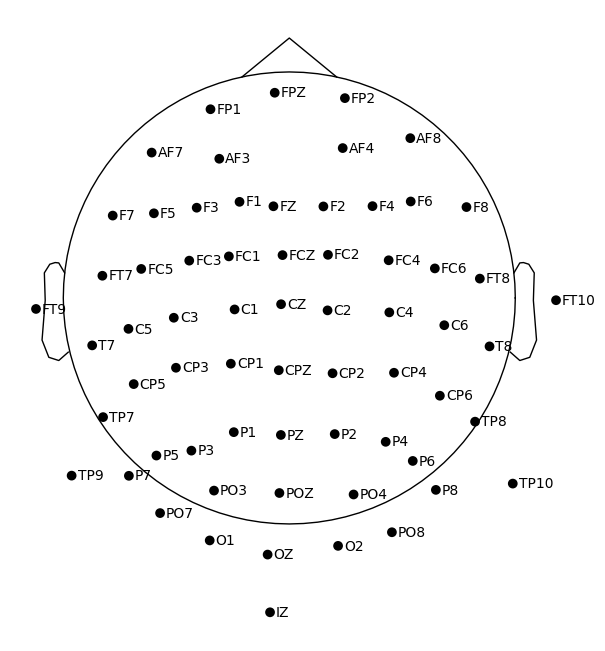

In [41]:
# plot montage
montage.plot(show_names=True)

________________________

**3. COREGISTRATION (manual)**

In [4]:
# MANUAL COREGISTRATION: 1 recording per subject
# DONE for younger AND older group

eeg_data_dir = 'C:\\Users\\a1902989\\Box\\Katya\\# PD project\\data_analysis\\source'
sub_with_session = 'PDc_s1_sub00_GR'
task = '_ARI'
task_stage = '_STOP'

fs_subject_dir = 'C:\\Users\\a1902989\\Box\\Katya\\# PD project\\pilot\\mri\\fs'
subject = 'PDc_sub00_GR'

info = os.path.join(eeg_data_dir, f'{sub_with_session}{task}{task_stage}_epochs_montage.fif')
mne.gui.coregistration(subject=subject,
                    subjects_dir=fs_subject_dir,
                    inst=info,
                    )

# COREG CHECK
# trans_file = os.path.join(source_path, f'{subject}-trans.fif')
# trans = mne.read_trans(trans_file)
# mne.gui.coregistration(subject=subject,
#                     subjects_dir=fs_subjects_dir,
#                     inst=info,
#                     trans=trans_file
#                     )

Using pyvistaqt 3d backend.
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Using low resolution head model in C:\Users\a1902989\Box\Katya\# PD project\pilot\mri\fs\PDc_sub00_GR\bem\PDc_sub00_GR-head.fif
Estimating fiducials from fsaverage.
Using low resolution head model in C:\Users\a1902989\Box\Katya\# PD project\pilot\mri\fs\PDc_sub00_GR\bem\PDc_sub00_GR-head.fif
Estimating fiducials from fsaverage.
Estimating fiducials from fsaverage.
Placing MRI fiducials - LPA
Using PDc_sub00_GR-head.fif for head surface.
    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read
Channel types::	eeg: 64
Placing MRI fiducials - LPA


In [ ]:
# CHECK COREGISTRATION
# optional

subject = os.listdir(subjects_dir)[0]
eeg_sub_path = os.path.join(eeg_data_dir, group, subject)
analysis_path = os.path.join(eeg_sub_path, 'preproc', 'analysis')
source_path = os.path.join(analysis_path, 'source')
epochs = mne.read_epochs(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'))

trans_file = os.path.join(source_path, f'{subject}-trans.fif')
trans = mne.read_trans(trans_file)
# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.
mne.viz.plot_alignment(
    info=epochs.info,
    trans=trans,
    subject=subject,
    dig=True,
    meg=["sensors"],
    subjects_dir=fs_subjects_dir,
    surfaces=["head-dense"],
)

Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\analysis\source\s1_pac_sub01_BL_plan-epo_montage.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
99 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\a1902989\AppData\Local\Temp\ipykernel_20948\1880293111.py:8: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\analysis\source\s1_pac_sub01_BL_plan-epo_montage.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'))


Using s1_pac_sub01-head-dense.fif for head surface.
    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read
Channel types::	eeg: 60


________________________________
STOPPED HERE

**4. Source space, BEM model, and forward solution**

subs 26 and 43 - manually fixed inner surface to fit into outer surface 

RuntimeError: Surface inner skull is not completely inside surface outer skull
Soluition:
mne watershed_bem -s subject_name -d SUBJECTS_DIR -p 20 --atlas --gcaatlas --overwrite

Do for subs: sub20, sub35, sub41, sub47


In [ ]:
subject

's1_pac_sub47'

In [ ]:
subjects_list[14] # [5, 9, 12, 14]

's1_pac_sub47'

In [ ]:
# SOURCE SPACE
# DONE for younger and older group

eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
task = '_BL'
task_stage = '_plan' # any task / stage can be used, since the source space is the same for all tasks
groups = ['O'] # 'Y', 'O'
conductivity = (0.3, 0.006, 0.3)  # for three layers
files_to_ignore = ['fsaverage_bem', 'morph-maps',
                   's1_pac_sub26_orig', 's1_pac_sub43_orig',
                   's1_pac_sub20_orig', 's1_pac_sub35_orig',
                   's1_pac_sub41_orig', 's1_pac_sub47_orig',
                   's1_pac_sub36_orig']

for group in groups:
    fs_subjects_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'
    subjects_list = [folder.name for folder in os.scandir(fs_subjects_dir) if folder.is_dir()]

    for subject in ['s1_pac_sub36']: # subjects_list:
        print(f"Setting up source space for subject: {subject}")
        if subject not in files_to_ignore:
            source_path = os.path.join(eeg_data_dir, group, subject, 'preproc', 'analysis', 'source')

            # Set up the source space
            src = mne.setup_source_space(
                subject,
                spacing="ico4", # ico4 - 2562 vertices per hemisphere
                add_dist="patch",
                subjects_dir=fs_subjects_dir 
            )

            # BEM model
            model = mne.make_bem_model(
                subject=subject, ico=4, conductivity=conductivity, subjects_dir=fs_subjects_dir
            )
            bem = mne.make_bem_solution(model)

            # Forward solution
            epochs = mne.read_epochs(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'))
            trans_file = os.path.join(source_path, f'{subject}-trans.fif')
            trans = mne.read_trans(trans_file)
            
            fwd = mne.make_forward_solution(
                info=epochs.info,
                trans=trans,
                src=src,
                bem=bem,
                eeg=True,
                n_jobs=-1
            )
            print(fwd)

            # SAVE source space, BEM model, and forward solution
            # Save the source space
            src_fname = os.path.join(source_path, f"{subject}-ico4-src.fif")
            mne.write_source_spaces(src_fname, src, overwrite=True)

            # Save BEM model
            bem_model_fname = os.path.join(source_path, f"{subject}-bem-model.fif")
            mne.write_bem_surfaces(bem_model_fname, model, overwrite=True)

            # Save BEM solution
            bem_sol_fname = os.path.join(source_path, f"{subject}-bem-sol.fif")
            mne.write_bem_solution(bem_sol_fname, bem, overwrite=True)

            # Save forward solution
            fwd_fname = os.path.join(source_path, f"{subject}-fwd.fif")
            mne.write_forward_solution(fwd_fname, fwd, overwrite=True)

            print(f"Saved all source modeling files to: {source_path}")

______________________

# LCMV

*Inverse operator - on evoked (higher snr); sources - on epochs (for PAC)*

**5. DATA and NOISE COVARIANCE MATRICES**

In [ ]:
os.listdir(eeg_data_dir)[13:14]

['s1_pac_sub47']

In [ ]:
# COMPUTE DATA and NOISE COVARIANCE MATRICES
# DONE for YOUNGER and OLDER group

# eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
groups = ['O'] # 'O'
tasks = ['_BL', '_MAIN']
task_stages = ['_plan', '_go'] # any task / stage can be used, since the source space is the same for all tasks
block_names = ['_baseline', '_adaptation']
rank_info = []

for group in groups:
    eeg_data_dir = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group}'

    for subject in os.listdir(eeg_data_dir)[13:14]:
        print(f"Setting up source space for subject: {subject}")
        analysis_dir = os.path.join(eeg_data_dir, subject, 'preproc', 'analysis')
        source_path = os.path.join(analysis_dir, 'source')

        for task in tasks:
            for task_stage in task_stages:
                for block_name in block_names:
                    if task == '_BL':
                        block_name = ''
                    else:
                        block_name = block_name
                    
                    epochs_file = os.path.join(analysis_dir, f'{subject}{task}_epochs{task_stage}{block_name}-epo.fif')
                    epochs = mne.read_epochs(epochs_file)

                    #! Change baseline for prestim period to get more different data and noise covariance matrices
                    epochs.apply_baseline(baseline=(-0.5, -0.001))
                    #! overwrite epochs with new baseline
                    epochs.save(os.path.join(analysis_dir, f'{subject}{task}_epochs{task_stage}{block_name}-epo.fif'), overwrite=True)

                    # evoked = epochs.average()
                    # evoked.plot()

                    rank = compute_rank(epochs, info=epochs.info) # check for rank deficiency - ALL GOOD: all epochs have rank 59
                    rank_info.append(f'Rank for {subject}{task}{task_stage}{block_name}: {rank}')

                    # Compute data and noise covariance matrices
                    data_cov = mne.compute_covariance(epochs, tmin=0, tmax=0.5, method='auto', rank='info')
                    # data_cov.plot(epochs.info)

                    noise_cov = mne.compute_covariance(epochs, tmin=-0.5, tmax=-0.001, method='auto', rank='info') # Use method='auto' when you want safe defaults for source localization and don't want to hand-tune covariance
                    # noise_cov.plot(epochs.info)

                    # Save covariance matrices
                    mne.write_cov(os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-data-cov.fif'), data_cov, overwrite=True)
                    mne.write_cov(os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-noise-cov.fif'), noise_cov, overwrite=True)
                    print(f"Covariance matrices saved for {subject}{task}{task_stage}{block_name}")
print(rank_info)

Setting up source space for subject: s1_pac_sub47
Reading D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub47\preproc\analysis\s1_pac_sub47_BL_epochs_plan-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 12 columns
103 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Applying baseline correction (mode: mean)
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Computing rank from data with rank=None
    Using tolerance 9.6e-12 (2.2e-16 eps * 60 dim * 7.2e+02  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 60 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)


In [ ]:
for i in rank_info:
    print(i)

Rank for s1_pac_sub47_BL_plan: {'eeg': 59}
Rank for s1_pac_sub47_BL_plan: {'eeg': 59}
Rank for s1_pac_sub47_BL_go: {'eeg': 59}
Rank for s1_pac_sub47_BL_go: {'eeg': 59}
Rank for s1_pac_sub47_MAIN_plan_baseline: {'eeg': 59}
Rank for s1_pac_sub47_MAIN_plan_adaptation: {'eeg': 59}
Rank for s1_pac_sub47_MAIN_go_baseline: {'eeg': 59}
Rank for s1_pac_sub47_MAIN_go_adaptation: {'eeg': 59}


In [ ]:
f'{subject}{task}{task_stage}{block_name}'
subject = 's1_pac_sub47'
task = '_BL'
task_stage = '_plan'
block_name = ''

's1_pac_sub47_BL_plan'

**6. COMPUTE AND APPLY LCMV FILTERS**

In [ ]:
eeg_data_dir = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group}'
os.listdir(eeg_data_dir)[9:10]

['s1_pac_sub36']

In [ ]:
data_cov

<Covariance | kind : full, shape : (60, 60), range : [-8e-11, +1.8e-10], n_samples : 25852>

In [ ]:
noise_cov

<Covariance | kind : full, shape : (60, 60), range : [-3.6e-11, +1.1e-10], n_samples : 25852>

In [ ]:
rank = compute_rank(epochs, info=epochs.info)
rank

Computing rank from data with rank=None
    Using tolerance 9.6e-12 (2.2e-16 eps * 60 dim * 7.2e+02  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 60 data channels with 1 projector


{'eeg': 59}

In [ ]:
# Compute data and noise covariance matrices
# data_cov = mne.compute_covariance(epochs, tmin=0, tmax=0.5, method='auto', rank='info')
data_cov.plot(epochs.info)

# noise_cov = mne.compute_covariance(epochs, tmin=-0.5, tmax=-0.001, method='auto', rank='info') # Use method='auto' when you want safe defaults for source localization and don't want to hand-tune covariance
noise_cov.plot(epochs.info)

Computing rank from covariance with rank=None
    Using tolerance 1.8e-13 (2.2e-16 eps * 60 dim * 14  max singular value)
    Estimated rank (eeg): 51
    EEG: rank 51 computed from 60 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 8.6e-14 (2.2e-16 eps * 60 dim * 6.5  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 60 data channels with 0 projectors


(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [ ]:
os.listdir(eeg_data_dir)[-2:]

['s1_pac_sub62', 's1_pac_sub68']

In [ ]:
# COMPUTE AND APPLY LCMV FILTERS
# DONE for YOUNGER and OLDER group

groups = ['O'] # 'O'
tasks = ['_BL', '_MAIN']
task_stages = ['_plan', '_go'] # any task / stage can be used, since the source space is the same for all tasks
block_names = ['_baseline', '_adaptation']

for group in groups:
    eeg_data_dir = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group}'

    for subject in os.listdir(eeg_data_dir):
        print(f"Setting up source space for subject: {subject}")
        analysis_dir = os.path.join(eeg_data_dir, subject, 'preproc', 'analysis')
        source_path = os.path.join(analysis_dir, 'source')
        stcs_folder = os.path.join(source_path, 'stcs')
        check_paths(stcs_folder)

        fwd_fname = os.path.join(source_path, f"{subject}-fwd.fif")
        forward = mne.read_forward_solution(fwd_fname)

        # Convert to fixed orientation (normal to cortex) AFTER computing the forward model
        fwd_fixed = mne.convert_forward_solution(forward, surf_ori=True, force_fixed=True)

        for task in tasks:
            for task_stage in task_stages:
                for block_name in block_names:
                    if task == '_BL':
                        block_name = ''
                    else:
                        block_name = block_name
                    
                    # Read epochs file
                    epochs_file = os.path.join(analysis_dir, f'{subject}{task}_epochs{task_stage}{block_name}-epo.fif')
                    epochs = mne.read_epochs(epochs_file)
                    evoked = epochs.average()

                    # Read data and noise covariance matrices
                    data_cov = mne.read_cov(os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-data-cov.fif'))
                    noise_cov = mne.read_cov(os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-noise-cov.fif'))
                    # Compute LCMV filters
                    filters = make_lcmv(
                                        evoked.info,
                                        fwd_fixed,
                                        data_cov,
                                        reg=0.05,
                                        noise_cov=noise_cov,
                                        pick_ori=None, # must be None when using fixed orientation
                                        weight_norm='unit-noise-gain-invariant',
                                        rank=None, # None; use 'info' to account for rank deficiency
                                    )
                    print(f"LCMV filters computed for {subject}{task}{task_stage}{block_name}")

                    # Apply LCMV filters to epochs
                    stcs = apply_lcmv_epochs(epochs, filters)
                    print(f"LCMV filters applied to epochs for {subject}{task}{task_stage}{block_name}")

                    # Save filters
                    filters_fname = os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-filters-lcmv.h5')
                    filters.save(filters_fname, overwrite=True)
                    
                    # Save source time courses
                    for i, stc in enumerate(stcs):
                        stc.save(os.path.join(stcs_folder, f'{subject}{task}{task_stage}{block_name}-stc-lcmv_epoch_{i:03d}'), overwrite=True)
                    print(f"Source time courses saved for {subject}{task}{task_stage}{block_name}")

Setting up source space for subject: s1_pac_sub62
Reading forward solution from D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub62\preproc\analysis\source\s1_pac_sub62-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (5124 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Reading D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub62\preproc\analysis\s1_pac_sub62_BL_epochs_plan-epo.fif ...
    Read a total of 1 projection items:
  

Move source estimates to subfolders

In [ ]:
# Set your source directory (where the original STC files are located)
# DONE
group = 'O'
eeg_data_dir = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group}'

for subject in os.listdir(eeg_data_dir):
    src_dir = Path(os.path.join(eeg_data_dir, subject, 'preproc', 'analysis', 'source', 'stcs'))

    # Set your destination directory
    dest_root = src_dir

    # Regex to parse the filename
    # Example: s1_pac_sub01_MAIN_plan_baseline-stc-lcmv_epoch_000-lh.stc
    pattern = re.compile(r'^(?P<subject>\w+)(?P<task>_BL|_MAIN)(?P<stage>_plan|_go)(?P<block>_baseline|_adaptation)?-stc-lcmv_epoch_\d+-[lr]h\.stc$')

    # Go through all STC files
    for file in src_dir.glob('*-stc-lcmv_epoch_*-??.stc'):
        match = pattern.match(file.name)
        if not match:
            print(f"Skipping unrecognized file: {file.name}")
            continue

        task = match.group('task')          # BL or MAIN
        stage = match.group('stage')        # plan or go
        block = match.group('block')        # baseline or adaptation (could be None for BL)

        # Build the destination path
        if task == '_BL':
            dest_path = dest_root / '_BL' / stage
        elif task == '_MAIN':
            if block is None:
                print(f"Missing block name for _MAIN task in file: {file.name}")
                continue
            dest_path = dest_root / '_MAIN' / stage / block
        else:
            print(f"Unknown task type: {task}")
            continue

        # Create destination folder if it doesn't exist
        dest_path.mkdir(parents=True, exist_ok=True)

        # Move the file (change to `shutil.copy` if you prefer to copy)
        shutil.move(str(file), dest_path / file.name)
        print(f"Moved {file.name} -> {dest_path}")


Moved s1_pac_sub12_BL_go-stc-lcmv_epoch_000-lh.stc -> D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub12\preproc\analysis\source\stcs\_BL\_go
Moved s1_pac_sub12_BL_go-stc-lcmv_epoch_000-rh.stc -> D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub12\preproc\analysis\source\stcs\_BL\_go
Moved s1_pac_sub12_BL_go-stc-lcmv_epoch_001-lh.stc -> D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub12\preproc\analysis\source\stcs\_BL\_go
Moved s1_pac_sub12_BL_go-stc-lcmv_epoch_001-rh.stc -> D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub12\preproc\analysis\source\stcs\_BL\_go
Moved s1_pac_sub12_BL_go-stc-lcmv_epoch_002-lh.stc -> D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub12\preproc\analysis\source\stcs\_BL\_go
Moved s1_pac_sub12_BL_go-stc-lcmv_epoch_002-rh.stc -> D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub12\preproc\analysis\source\stcs\_BL\_go
Moved s1_pac_sub12_BL_go-stc-lcmv_epoch_003-lh.stc -> D:\B

**7. Morphing the sources to the default brain**

In [ ]:
# Create a source space for the default brain
# DONE
group = 'O'
mri_data_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'
fs_subject = 'fsaverage_bem'

src = mne.setup_source_space(subject=fs_subject,
                              spacing="ico4",  # alternatives: 'oct5', 'ico5', 'ico4', etc.
                              add_dist="patch",
                              subjects_dir=mri_data_dir
                              )

mne.write_source_spaces(f'{mri_data_dir}/{fs_subject}/bem/fsaverage-ico4-src.fif', src, overwrite=True)

Setting up the source space with the following parameters:

SUBJECTS_DIR = D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y
Subject      = fsaverage_bem
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\fsaverage_bem\surf\lh.white...
Mapping lh fsaverage_bem -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\fsaverage_bem\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/163842 selected to source space (ico = 4)

Loading D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\fsaverage_bem\surf\rh.white...
Mapping rh fsaverage_bem -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\Bono

In [ ]:
fig = src.plot(brain=True)

# Access the underlying PyVista Plotter
plotter = fig.plotter

# Now you can change the background color
plotter.set_background("white")  # or "black", or (1, 1, 1) for RGB

In [ ]:
# Create subfolders for morphed STCs
# DONE

group = 'O'
tasks = ['_BL', '_MAIN']
task_stages = ['_plan', '_go']
block_names = ['_baseline', '_adaptation']
eeg_data_dir = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group}'

for subject in os.listdir(eeg_data_dir):
    analysis_dir = os.path.join(eeg_data_dir, subject, 'preproc', 'analysis')
    source_path = os.path.join(analysis_dir, 'source')
    morphed_folder = os.path.join(source_path, 'morphed_stcs')
    check_paths(morphed_folder)

    for task in tasks:
        task_folder = os.path.join(morphed_folder, task)
        check_paths(task_folder)
        for task_stage in task_stages:
            task_stage_folder = os.path.join(task_folder, task_stage)
            check_paths(task_stage_folder)
            for block_name in block_names:
                if task == '_BL':
                    block_name = ''
                else:
                    block_name = block_name
                    bloch_name_folder = os.path.join(task_stage_folder, block_name)
                    check_paths(bloch_name_folder)
    print(f"Morphed STCs folders created for subject: {subject}")


Morphed STCs folders created for subject: s1_pac_sub12
Morphed STCs folders created for subject: s1_pac_sub14
Morphed STCs folders created for subject: s1_pac_sub15
Morphed STCs folders created for subject: s1_pac_sub17
Morphed STCs folders created for subject: s1_pac_sub20
Morphed STCs folders created for subject: s1_pac_sub21
Morphed STCs folders created for subject: s1_pac_sub23
Morphed STCs folders created for subject: s1_pac_sub34
Morphed STCs folders created for subject: s1_pac_sub35
Morphed STCs folders created for subject: s1_pac_sub36
Morphed STCs folders created for subject: s1_pac_sub40
Morphed STCs folders created for subject: s1_pac_sub41
Morphed STCs folders created for subject: s1_pac_sub45
Morphed STCs folders created for subject: s1_pac_sub47
Morphed STCs folders created for subject: s1_pac_sub48
Morphed STCs folders created for subject: s1_pac_sub49
Morphed STCs folders created for subject: s1_pac_sub50
Morphed STCs folders created for subject: s1_pac_sub53
Morphed ST

In [ ]:
# MORPH SOURCE ESTIMATES TO FSAVERAGE SPACE
# DONE for YOUNGER group

groups = ['O'] # 'O'
tasks = ['_BL', '_MAIN']
task_stages = ['_plan', '_go'] # any task / stage can be used, since the source space is the same for all tasks
block_names = ['_baseline', '_adaptation']

for group in groups:
    mri_data_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'
    # Path to the fsaverage source space
    fname_fsaverage_src = os.path.join(mri_data_dir, "fsaverage_bem", "bem", "fsaverage-ico4-src.fif")

    eeg_data_dir = os.path.join('D:\\BonoKat\\research project\\# study 1\\eeg_data\\set', group)

    for subject in os.listdir(eeg_data_dir):
        print(f"Setting up source space for subject: {subject}")
        source_dir = os.path.join(eeg_data_dir, subject, 'preproc', 'analysis', 'source')
        morphed_dir = os.path.join(source_dir, 'morphed_stcs')

        # Read the original source space and forward solution
        fname_src = os.path.join(source_dir, f"{subject}-ico4-src.fif")
        fname_fwd =  os.path.join(source_dir, f"{subject}-fwd.fif")

        for task in tasks:
            for task_stage in task_stages:
                for block_name in block_names:
                    if task == '_BL':
                        block_name = ''
                    else:
                        block_name = block_name
                    
                    fname_stcs = os.path.join(source_dir, 'stcs', task, task_stage, block_name)

                    # Read stc from file (only left hemisphere is mentioned, since MNE reads both hemispheres automatically)
                    stcs = [mne.read_source_estimate(os.path.join(fname_stcs, fname_stc)) for fname_stc in os.listdir(fname_stcs) if fname_stc.endswith('-lh.stc')]
                    
                    # Read the fsaverage source space
                    src_to = mne.read_source_spaces(fname_fsaverage_src)

                    # Morph the source estimates to the fsaverage space
                    morph = mne.compute_source_morph(
                        stcs[0],
                        subject_from=subject,
                        subject_to="fsaverage_bem",
                        src_to=src_to,
                        subjects_dir=mri_data_dir,
                        smooth=5 # small smoothing to avoid artifacts in the morphed data
                    )

                    # Apply the morphing to each stc and save the morphed stcs
                    stcs_morphed = []
                    for stc in stcs:
                        # Apply the morphing to each stc
                        stc_fsaverage = morph.apply(stc)
                        stcs_morphed.append(stc_fsaverage)
                    
                    # Save morphed source time courses
                    for i, stc_morphed in enumerate(stcs_morphed):
                        stc_morphed.save(os.path.join(morphed_dir, task, task_stage, block_name, f'{subject}{task}{task_stage}{block_name}-stc-lcmv_epoch_{i:03d}_morphed'), overwrite=True)
                    
                    print(f"Source time courses saved for {subject}{task}{task_stage}{block_name}")

END HERE

____________________________________